In [1]:
from model import Model
import pennylane as qml
import pennylane.numpy as np

In [ ]:
name = 'phong_2_simple'


def func(n, phi):
	return np.cos(phi) ** n


consts = {'ks': 0.5}
scalars = {'n': {'range': (2, 2), 'type': np.uint32}}
angles = {'phi': {'range': (0, np.pi / 2)}}

In [3]:
model = Model(name)
model.set_function(func)
# model.set_consts(consts)
model.set_scalars(scalars)
model.set_angles(angles)

model.set_sample_size(50)

try:
	model.read_samples('samples/' + model.name + '.bin')
except FileNotFoundError:
	model.generate_samples()
	model.read_samples('samples/' + model.name + '.bin')

model.separate()

(<Figure size 2500x300 with 1 Axes>, <Axes: >)

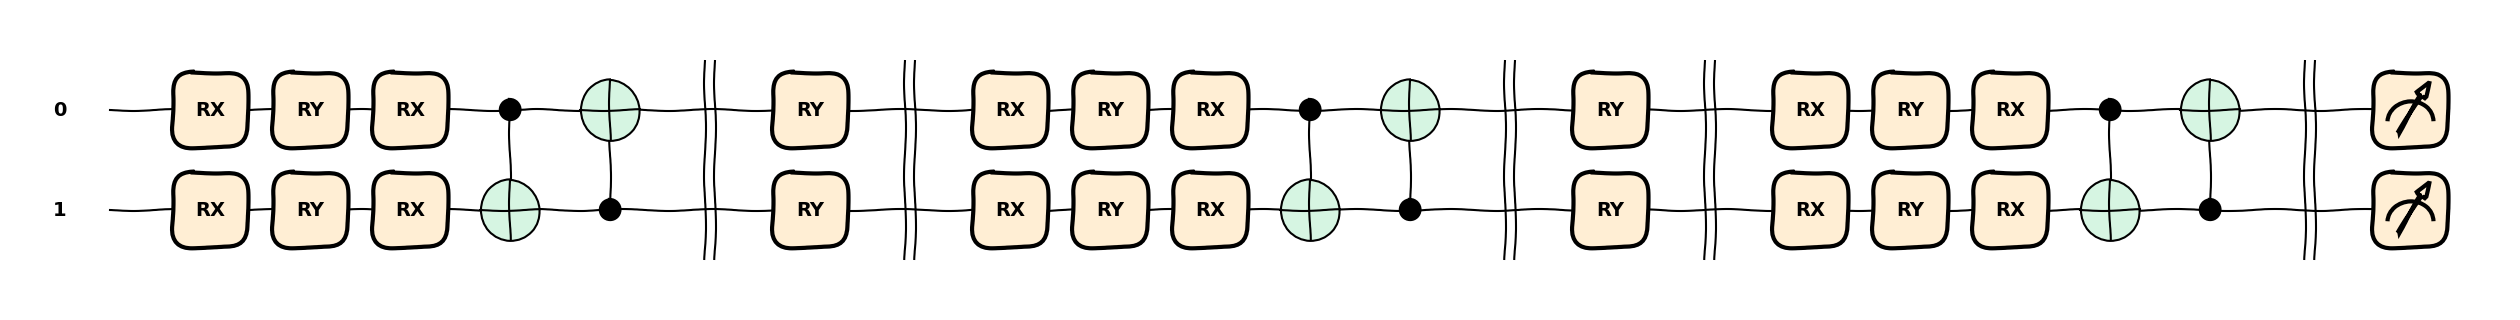

In [ ]:
n_qubits = 2
layers = 4

model.push_extra('n_qubits', n_qubits)
model.push_extra('layers', layers)
model.generate_device(n_qubits)


def embedding(data, n_qubits):
	for i in range(n_qubits):
		if i < len(model.scalars):
			value = data[i]
			name = model.header[i + len(model.consts)]
			(min, max) = model.scalars.get(name).get('range')
			if min == max:
				value = value / max * np.pi / 2
			else:
				value = (value - min) / (max - min) * np.pi
			qml.RY(value, wires=i)
		else:
			qml.RY(data[i], wires=i)

	qml.Barrier()


def rot_ent(params, n_qubits):
	if len(params) < n_qubits * 3:
		raise ValueError('Not enough params')

	for i in range(n_qubits):
		qml.RX(params[3 * i], wires=i)
		qml.RY(params[3 * i + 1], wires=i)
		qml.RX(params[3 * i + 2], wires=i)

	for i in range(n_qubits):
		qml.CNOT(wires=[i, (i + 1) % n_qubits])

	qml.Barrier()


model.push_extra('embedding', embedding)
model.push_extra('rot_ent', rot_ent)


def _circuit(data, params):
	layers = model.extra.get('layers')
	n_qubits = model.extra.get('n_qubits')

	model.extra.get('rot_ent')(params, n_qubits)
	for i in range(layers):
		temp_params = params[i * n_qubits * 3 : (i + 1) * n_qubits * 3]
		model.extra.get('embedding')(data, n_qubits)
		model.extra.get('rot_ent')(temp_params, n_qubits)

	return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))


def _model(circ, input, params):
	return (circ(input, params) + 1) / 2


model.set_model(_model)
model.set_circuit(_circuit)
model.generate_params((n_qubits * 3 * (layers + 1),))

qml.draw_mpl(model.circuit, style='sketch')(model.train_in, model.params)

In [5]:
model.optimizer = qml.AdamOptimizer(stepsize=0.05)

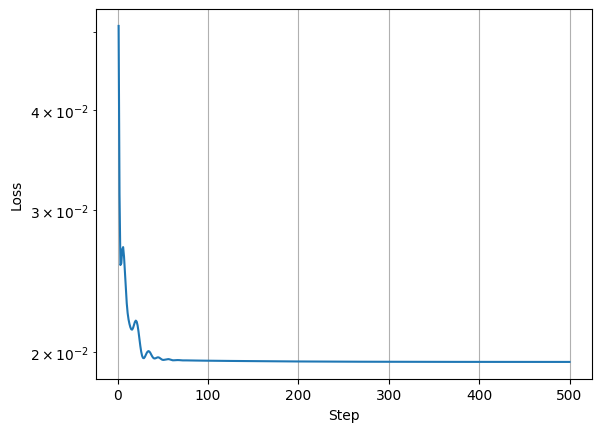

Loss: 0.019439341278752846
Step 500
Estimated time remaining: 00:00:00:000


In [6]:
model.set_max_steps(500)
model.set_objective(1e-6)
model.optimization(objective=True, callback='graph')

In [7]:
print('Test score:', model.test())

Test score: 0.018769608840099223


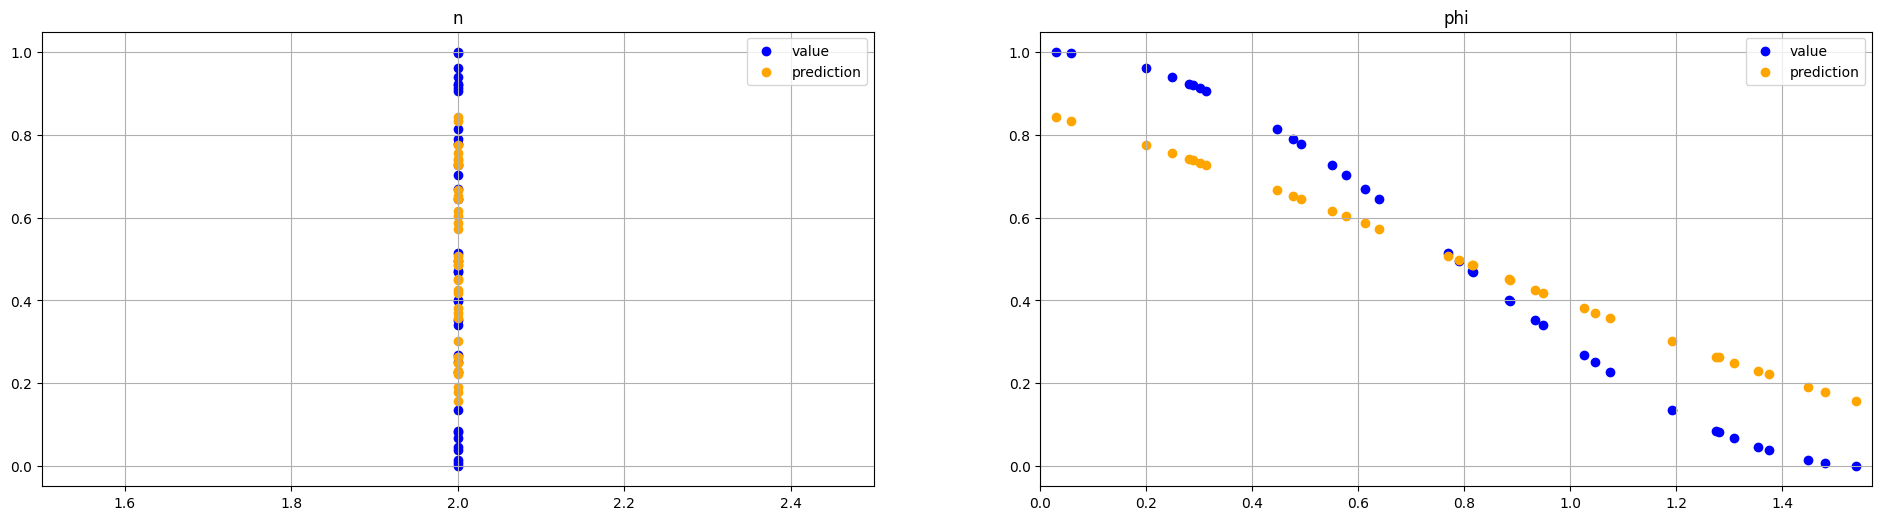

In [8]:
model.draw_train()

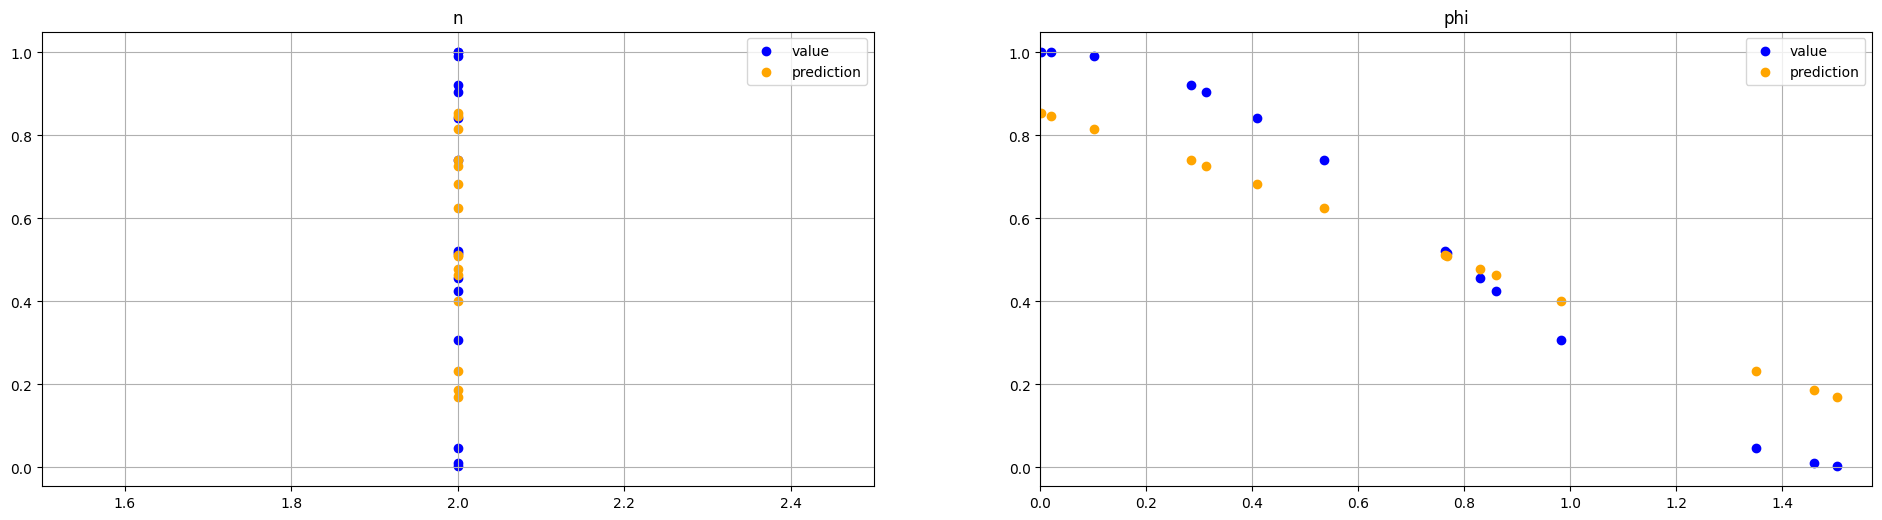

In [9]:
model.draw()

In [10]:
model.serialize('models/' + model.name + '.json')